# Regresia logistică

Resurse utile:

[1] [Cross entropy for dummies](https://towardsdatascience.com/cross-entropy-for-dummies-5189303c7735)

[2] [Understanding logistic regression](https://towardsdatascience.com/understanding-logistic-regression-step-by-step-704a78be7e0a)

[3] [Cross entropy log loss and intuition behind it](https://towardsdatascience.com/cross-entropy-log-loss-and-intuition-behind-it-364558dca514)

[4] [Cross entropy (a se vedea secţiunea "Relation with log-likelihood")](https://en.wikipedia.org/wiki/Cross_entropy)

In [167]:
import numpy as np
import matplotlib.pyplot as plt
import csv
import functools
import pandas as pd
from typing import Union

plt.rc('font', **{'size' : 18})

In [168]:
!pip install tableprint
import tableprint as tab

## Introducere

Regresia liniară 'potriveşte' o funcţie liniară (polinomială) folosind un set de date $X$, pe tot domeniul $\mathbb{R}$, $linreg(x) : \mathbb{R}^m \rightarrow \mathbb{R}$. Regresia logistică are acelaşi domeniu, însă codomeniul este un set mult mai restrâns, şi anume $logreg(x) : \mathbb{R}^n \rightarrow (0, 1)$. Aceasta încearcă să prezică probabilitatea ca elementul $x \in X$ să facă parte din clasa pozitivă.

Această probabilitate o notăm cu $P(y=1|x,\theta)$, şi o interpretăm ca fiind probabilitatea asociată răspunsului $x^T \theta$ calculat de regresia clasică, în condiţiile în care cunoaştem feature-urile $X$ şi parametrii $\theta$ ai modelului.

Ideea este că pentru fiecare intrare $x$, modelul regresiei logistice asociază o probabilitate. Vom arăta cum alegem funcţia care calculează probabilitatea folosind răspunsul regresiei liniare $x^T \theta$.

Pornim de la o funcţie care are ca parametru o probabilitate şi care mapează intervalul $(0,1)$ în toată axa reală $\mathbb{R}$. Observăm cum funcţia $f_1(p) = \frac{p}{1-p}$ mapează probabilitatea în $\mathbb{R}^+$, iar dacă aplicăm logaritmul, funcţia $f_2(p) = log\left(\frac{p}{1-p}\right)$ mapează intervalul $(0, 1)$ în toată axa reală $\mathbb{R}$:

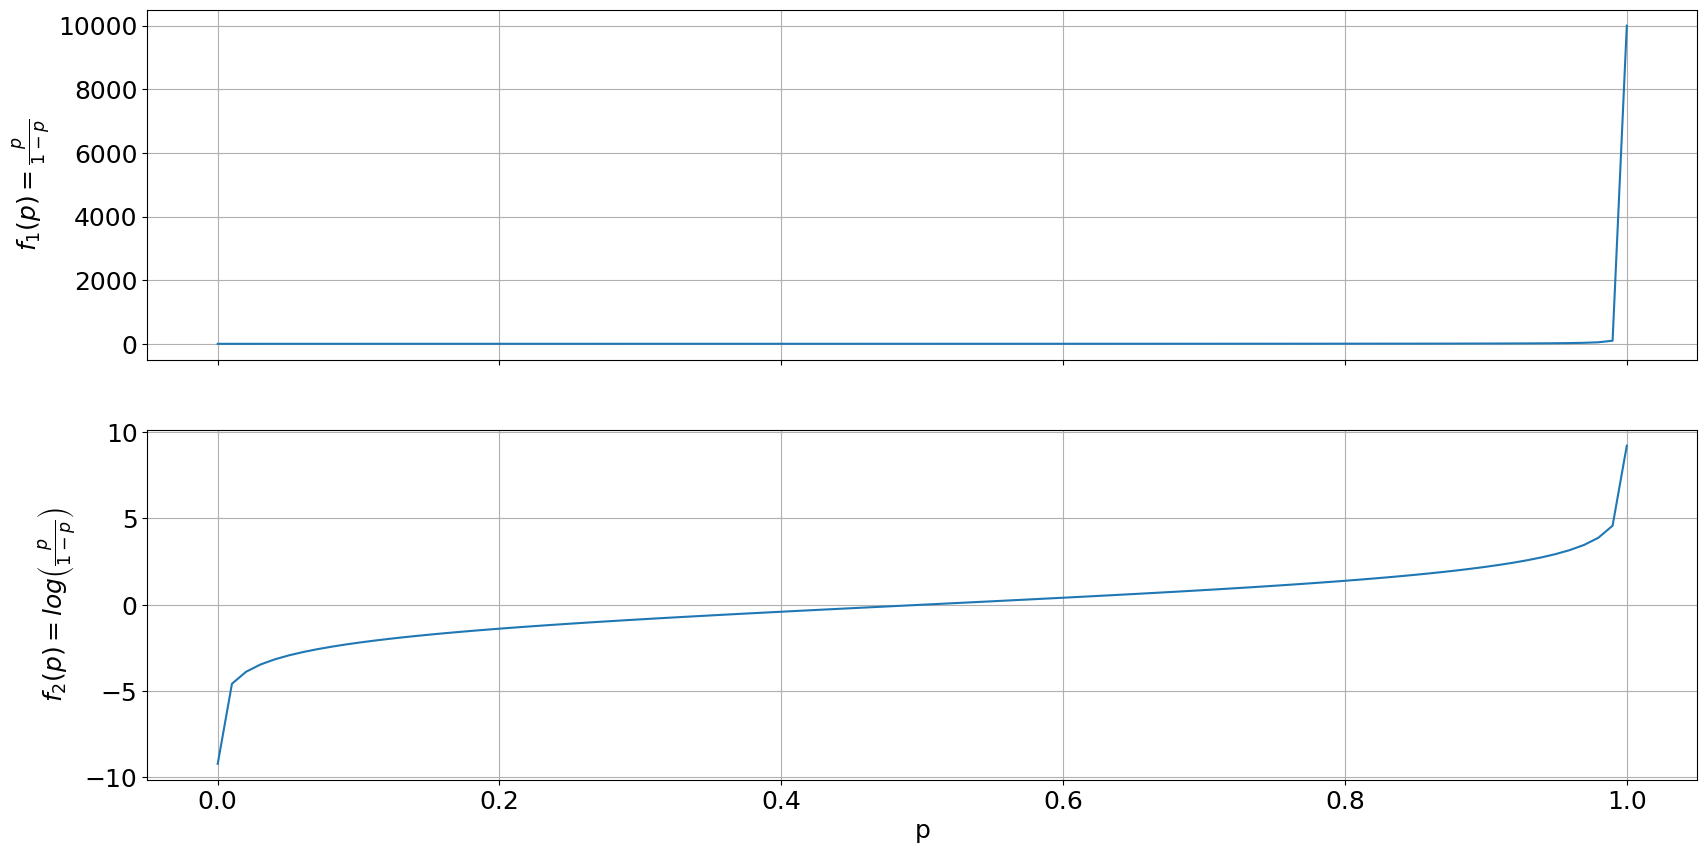

In [169]:
f1 = lambda x: x / (1 - x)
f2 = lambda x: np.log(x / (1 - x))
x = np.linspace(1e-4, 1-1e-4, 100)

fig, ax = plt.subplots(2, 1, figsize=(20, 10), sharex=True)
ax[0].plot(x, f1(x)) ; ax[1].plot(x, f2(x))
ax[0].set_ylabel(r'$f_1(p) = \frac{p}{1-p}$') ; ax[0].grid()
ax[1].set_xlabel('p') ; ax[1].set_ylabel(r'$f_2(p) = log\left(\frac{p}{1-p}\right)$') ; ax[1].grid()
plt.show()

Observaţi că dacă răspunsul dat de regresie este 0 ($f_2(p) = 0$), probabilitatea asociată este 0.5. Ne interesează ca răspunsul calculat de regresie (care poate fi orice valoare de pe axa reală) să fie egal cu această funcţie de probabilitate:

$$h_{\theta}(x) = x^T \theta = log\left(\frac{p}{1-p}\right)$$

Mai departe, prin câteva transformări algebrice, putem arăta că:

$$\hat{y} = P(y=1|x, \theta) = p = \frac{1}{1 + e^{-h_{\theta}(x)}}$$

Avem astfel o funcţie care mapează $x$ şi parametrii modelului $\theta$ într-o probabilitate. Funcţia este denumită funcţie logistică.

În realitate, avem setul de date $X$ şi asociat fiecărui $x_i$, $i=1 \dots m$, o valoare binară $y_i \in \{0, 1\}$. De fapt, setul de date $X$ este caracterizat de o distribuţie de probabilitate foarte simplă, distribuţie în care probabilităţile pot lua doar valorile 0 şi 1. Dacă am pune valorile $x_i$ pe abscisă şi valorile $y_i$ pe ordonată, graficul distribuţiei ar fi foarte accidentat - în fond, y ia doar două valori.

Am vrea ca modelul nostru caracterizat de coeficienţii $\theta$ să se 'potrivească' cât mai bine peste această distribuţie dată iniţial - probabil peisajul funcţiei de distribuţie a modelului nu mai este atât de rugos, ci mai neted (continuu, vălurit). Bineînteles acest exemplu este unul exagerat, în realitate spaţiul de intrare $X$ este unul $m$ dimensional, nu 1-dimensional cum am presupus aici ca să ne imaginăm reprezentarea distribuţiilor de probabilitate.

Pentru ca să putem compara însă 'cât de bine' se potriveşte distribuţia modelului pe care îl învăţăm cu distribuţia iniţială, avem nevoie de o măsură a acestor distribuţii. Pentru aceasta vom introduce noţiunea de entropie ca măsură a informaţiei.

## Regresia logistică binomială

Funcţia de cost pentru regresia logistică este dată de cross-entropia binară, scrisă sub formă vectorială astfel:

$$
J(\theta) = -\frac{1}{m} \left(\mathbf{y}^t \cdot \ln \hat{\mathbf{y}} + (1-\mathbf{y})^t \cdot \ln ( \mathbb{1}_m - \hat{\mathbf{y}}) \right) 
$$

Gradientul functiei de cost este:

$$
\nabla_{\theta} J(\theta) = \frac{1}{m} \mathbf{X}^t (\hat{\mathbf{y}} - \mathbf{y})
$$

Modificarea ponderilor din vectorul $\boldsymbol{\theta}$ se face la fiecare iteratie (epoca) cu:
$$
\boldsymbol{\theta} = \boldsymbol{\theta} - \alpha\frac{1}{m} \mathbf{X}^t (\hat{\mathbf{y}} - \mathbf{y})
$$
cu $\alpha > 0$ rata de invatare. 

### Încărcarea setului de date

In [170]:
path_train = './data/mnist_train.csv'
path_test = './data/mnist_test.csv'

train_set = pd.read_csv(path_train, header=None).values
test_set = pd.read_csv(path_test, header=None).values

assert(train_set.shape) == (60000, 785)
assert(test_set.shape) == (10000, 785)

In [171]:
# train_set si test_set sunt matrice care contin pe prima coloana clasa (o cifra de la 0 la 9),
#  iar imaginea este pastrata incepand de pe coloana 1 pana la terminare.
# Decupati in train_x doar imaginile iar in train_y doar clasa,
#  si faceti acelasi lucru si pentru test_x si test_y
train_x, train_y = train_set[:,1:], train_set[:, 0]
test_x, test_y = test_set[:,1:], test_set[:, 0]

assert train_x.shape == (60000, 784)
assert train_y.shape == (60000,)
assert test_x.shape == (10000, 784)
assert test_y.shape == (10000,)

Să vizualizăm setul de date. Vom observa primele 16 linii din setul de antrenare:

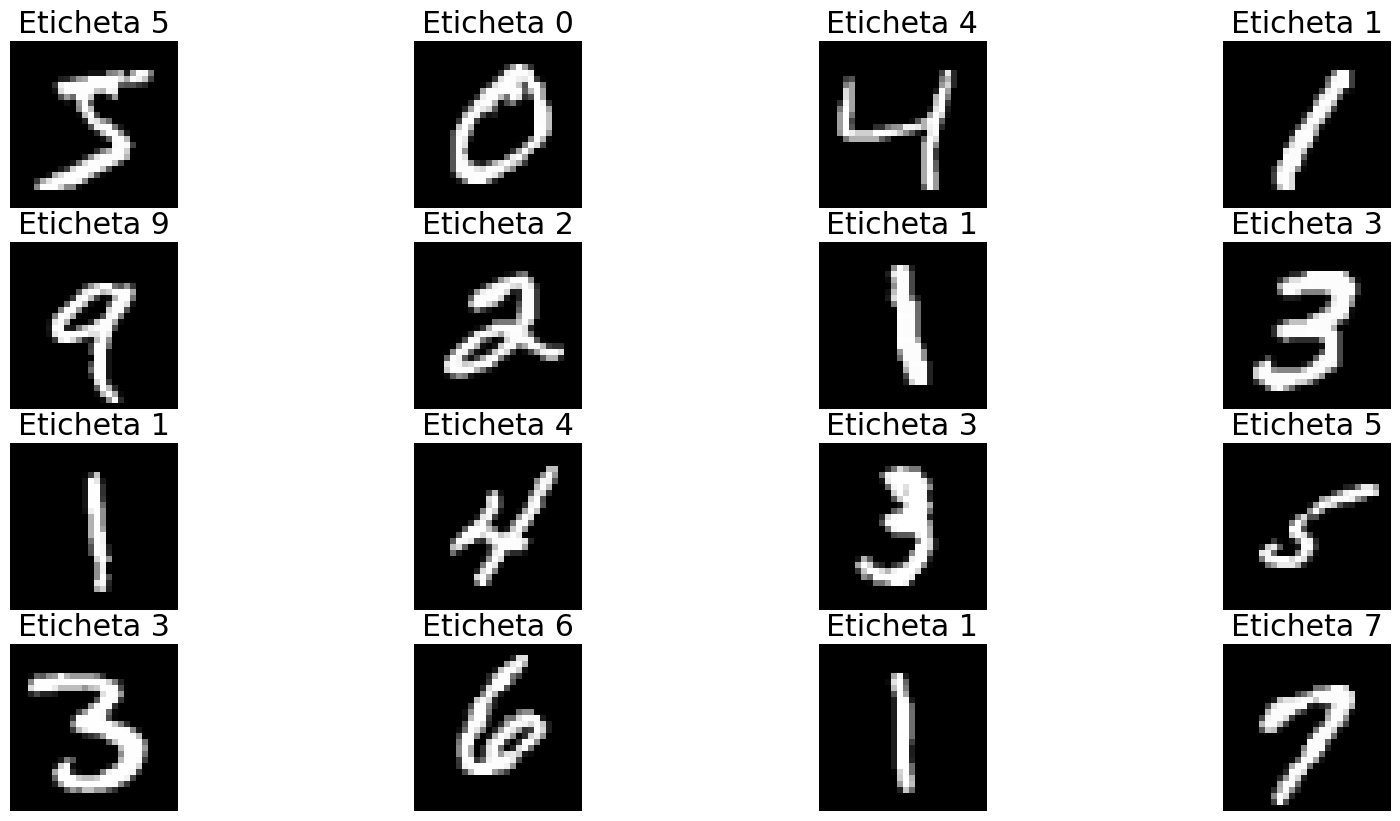

In [172]:
def show_samples(x_set, y_set):
    size = x_set.shape[0]
    
    fig, ax = plt.subplots(size // 4, 4, figsize=(20, 10))
    for k in range(size):
        row, col = k // 4, k % 4
        
        # Make those columns into a array of 8-bits pixels
        # The pixel intensity values are integers from 0 to 255
        pixels = np.array(x_set[k], dtype='uint8')    
        
        # Reshape the array into 28 x 28 array (2-dimensional array)
        n = int(np.sqrt(len(pixels)))
        assert n**2 == len(pixels)
        pixels = pixels.reshape(n, n)
        ax[row, col].imshow(pixels, cmap='gray')
        ax[row, col].set_title('Eticheta {label}'.format(label=y_set[k]))
        ax[row, col].axis('off')

    plt.show()
    
show_samples(train_x[:16, :], train_y[:16])

Pentru regresia binomială, ne interesează să clasificăm deocamdată doar imaginile corespunzătoare a două clase, de exemplu pentru cifrele '0' şi '1'. Vom defini seturile care 'decupează' doar aceste două clase din seturile date:

In [173]:
# Filtrati din seturile mari doar acele sample-uri corespunzatoare cifrelor 0 si 1
# determinati vectorii logici cu True pentru indicii pt care clasele din vectorii y sunt 0 sau 1 si False in rest
labels_0_1_train = np.logical_or(train_y == 0, train_y == 1)
labels_0_1_test = np.logical_or(test_y == 0, test_y == 1)

assert labels_0_1_train.shape == (60000,)
assert labels_0_1_test.shape == (10000,)

assert labels_0_1_train.sum() == 12665
assert labels_0_1_test.sum() == 2115

# # Filtrati din seturile mari doar acele sample-uri corespunzatoare cifrelor 0 si 1. 
# Puteti folosi reshape pentru vectorii y 
# Folositi vectorii logici labels_0_1_train si labels_0_1_test pentru filtrare

train_x_bin, train_y_bin = np.delete(train_x, np.where(labels_0_1_train == False), axis = 0),np.delete(train_y, np.where(labels_0_1_train == False), axis = 0)
test_x_bin, test_y_bin = np.delete(test_x, np.where(labels_0_1_test == False), axis = 0),np.delete(test_y, np.where(labels_0_1_test == False), axis = 0)
train_y_bin = train_y_bin.reshape((labels_0_1_train.sum(),1))
test_y_bin = test_y_bin.reshape((labels_0_1_test.sum(),1))

assert train_x_bin.shape == (12665, 784)
assert train_y_bin.shape == (12665, 1)
assert test_x_bin.shape == (2115, 784)
assert test_y_bin.shape == (2115, 1)

 La fel ca si la regresia liniară, prima coloană trebuie să fie formată doar din cifra 1:

In [174]:
def add_ones_column(x: np.ndarray) -> np.ndarray:
    """
    Returns a matrix with first column filled with 1 and the other columns being x's columns.
    """
    # ...
    new_mat = np.insert(x,0,1,axis=1)
    return new_mat

train_x_bin_ext = add_ones_column(train_x_bin)
test_x_bin_ext = add_ones_column(test_x_bin)

assert train_x_bin_ext.shape == (12665, 785)
assert test_x_bin_ext.shape == (2115, 785)
assert np.all(train_x_bin_ext[:, 0] == 1)
assert np.all(test_x_bin_ext[:, 0] == 1)

Feature-urile trebuiesc normalizate, valoarea maximă fiind 255. Normalizarea urmăreşte ca toate featurile rezultate să fie în intervalul \[0, 1\], deci vom împărţi la valoarea maximă.

In [175]:
def normalize(x: np.ndarray) -> np.ndarray:
    """
    Normalization means division by 255.
    
    Args:
        x: feature matrix, shape m * n. It will not be changed by this code.
    
    Returns:
        matrix with scaled values between 0 and 1, of same shape
    """

    return (x/255)

train_x_bin_ext = add_ones_column(normalize(train_x_bin))
test_x_bin_ext = add_ones_column(normalize(test_x_bin))

assert train_x_bin_ext.shape == (12665, 785)
assert test_x_bin_ext.shape == (2115, 785)
assert np.all(train_x_bin_ext[:, 0] == 1)
assert np.all(test_x_bin_ext[:, 0] == 1)
assert np.all(train_x_bin_ext <= 1)
assert np.all(test_x_bin_ext <= 1)
assert np.all(train_x_bin_ext >= 0)
assert np.all(test_x_bin_ext >= 0)

Calculăm funcţia sigmoidă, $sigmoid(z) = \frac{1}{1 + e^{-z}}$ respectiv $\hat y = h(x, \theta) = sigmoid \left( X  \theta \right)$:

In [176]:
def sigmoid(z: Union[float, np.ndarray]) -> Union[float, np.ndarray]:
    return (1/(1+ np.exp(-z)))

assert sigmoid(0) == 0.5
assert np.abs(sigmoid(1) - 0.731058) < 1e-6

def h(x: Union[float, np.ndarray], theta: Union[float, np.ndarray]) -> Union[float, np.ndarray]:
    return sigmoid(np.dot(x,theta))

assert np.abs(h(np.array([1., 1., 1., 0]), np.array([1., 0., 1., 1.])) - 0.880797) < 1e-6

Calculăm funcţia de cost cu regularizare de data aceasta (atenţie, coeficientul $\theta_0$ nu se regularizează):

\begin{align}
J(\boldsymbol\theta) & = \underbrace{-\frac{1}{m} \sum\limits_{i=1}^m \left[y^{(i)}\cdot \ln h_{\boldsymbol\theta}(\mathbf{x}^{(i)}) + (1-y^{(i)})\cdot \ln (1- h_{\boldsymbol\theta}(\mathbf{x}^{(i)})) \right]}_{\text{Eroarea de calitate}} 
\\
& + \underbrace{\frac{\lambda}{2} \sum\limits_{j=1}^n \theta_j^2}_{\text{termenul de regularizare}}
%\label{eq:JCrossEntropyRegularizare}
\\
& = 
\underbrace{-\frac{1}{m} \sum\limits_{i=1}^m \left[y^{(i)}\cdot \ln \hat y^{(i)}  + (1-y^{(i)})\cdot \ln (1- \hat y^{(i)}) \right]}_{\text{Eroarea de calitate}} 
\\
& + \underbrace{\frac{\lambda}{2} \sum\limits_{j=1}^n \theta_j^2}_{\text{termenul de regularizare}}
\\
& = -\frac{1}{m} \left(\mathbf{y}^t \cdot \ln\hat{\mathbf{y}}  + (\mathbb{1}-\mathbf{y})^t \cdot \ln(\mathbb{1}-\hat{\mathbf{y}})\right) + \frac{\lambda}{2} \| \boldsymbol\theta[1:]  \|^2_2
\end{align}

unde $\boldsymbol\theta[1:]$ este vectorul format din toate componentele lui $\boldsymbol\theta$ mai puțin prima, iar $\| \mathbf{v} \|_2$ este norma Euclidiană a vectorului $\mathbf{v}$.

In [177]:
def cost(x, y, theta, lmbda):
    """
    Cost function includes also regularization
    
    Args:
        x: matricea feature-urilor, dimensiune m x (n+1)
        y: vectorul evidentei, dimensiune m x 1
        theta: vectorul coeficientilor, dimensiune (n+1) x 1
        
    Returns:
        costul, ca scalar
    """
    assert x.shape[1] == theta.shape[0]
    assert x.shape[0] == y.shape[0]
    assert theta.shape[1] == y.shape[1] == 1
    assert lmbda >= 0
    # calculam y hat:
    y_hat = h(x,theta)
    # calculam eroarea de calitate
    m = x.shape[0]
    j1 = (-1/m) * np.sum(np.add(np.multiply(y, np.log(y_hat)), np.multiply(np.subtract(1,y), np.log(1-y_hat))))
    # calculam eroarea de regularizare
    j2= np.multiply(np.divide(lmbda,2), np.sum(np.power(theta[1:],2)))
    return j1 + j2

np.random.seed(11)
n = train_x_bin_ext.shape[1]
theta = np.random.randn(n).reshape(n, 1)
# print(cost(train_x_bin_ext, train_y_bin, theta=theta, lmbda=0.2))
assert np.abs(cost(train_x_bin_ext, train_y_bin, theta=theta, lmbda=0.2) - 79.815566) < 1e-6

Calculăm gradientul, folosind expresia determinată anterior, şi ţinând seama de termenul de regularizare:

$$
\nabla_{\boldsymbol{\theta}} J(\boldsymbol{\theta}) = \frac{1}{m} \mathbf{X}^t(\hat{\mathbf{y}} - \mathbf{y}) + \lambda (0, \theta_1, \dots, \theta_n)
$$

In [178]:
def grad(x, y, theta, lmbda):
    """
    Computation of gradient with regularization term
    
    Args:
        x: matricea feature-urilor, dimensiune m x (n + 1)
        y: vectorul evidentei, dimensiune m
        theta: vectorul coeficientilor, dimensiune n+1
        lmbda: coeficientul de regularizare
        
    Returns:
        gradientul, vector de n+1 elemente
    """
    m = x.shape[0]
    y_hat = h(x,theta)
    g1 = (1/m) * np.dot(np.transpose(x), np.subtract(y_hat, y)) # gradientul de calitate, fara regularizare
    
    theta_simple = theta.copy()
    theta_simple[0] = 0
    g2 = np.dot(lmbda, theta_simple) # gradientul aferent termenului de regularizare
    
    g = g1 + g2
    assert g.shape == theta.shape
    return g

np.random.seed(11)
n = train_x_bin_ext.shape[1]
theta = np.random.randn(n).reshape(n, 1)
res = grad(train_x_bin_ext, train_y_bin, theta=theta, lmbda=0.2)
assert res.shape == (785, 1)

Algoritmul de antrenare va stoca costul asociat fiecărei epoci într-o listă:

In [179]:
def compute_accuracy(x_set, y_set, theta):
    pred = ((h(x_set, theta) >= 0.5) * 1 == y_set)
    return 100.0 * sum(pred) / pred.shape[0]

In [180]:
# Set learning rate
eta = 0.2

# Set regularization coefficient
lmbda = 0.5

# In x, we have m instances of n features each
# Create theta as a vector (n x 1)
n = np.shape(train_x_bin_ext)[1]
theta = np.random.randn(n).reshape(n, 1)

# Do the training
epochs = 40
values = []
accurracies = []
for i in range(epochs):
    theta -= eta * grad(train_x_bin_ext, train_y_bin, theta, lmbda)
    acc = compute_accuracy(train_x_bin_ext, train_y_bin, theta)
    values.append(cost(train_x_bin_ext, train_y_bin, theta, lmbda))
    accurracies.append(acc)
    
print("last cost: %g" % values[-1])

last cost: 0.273241


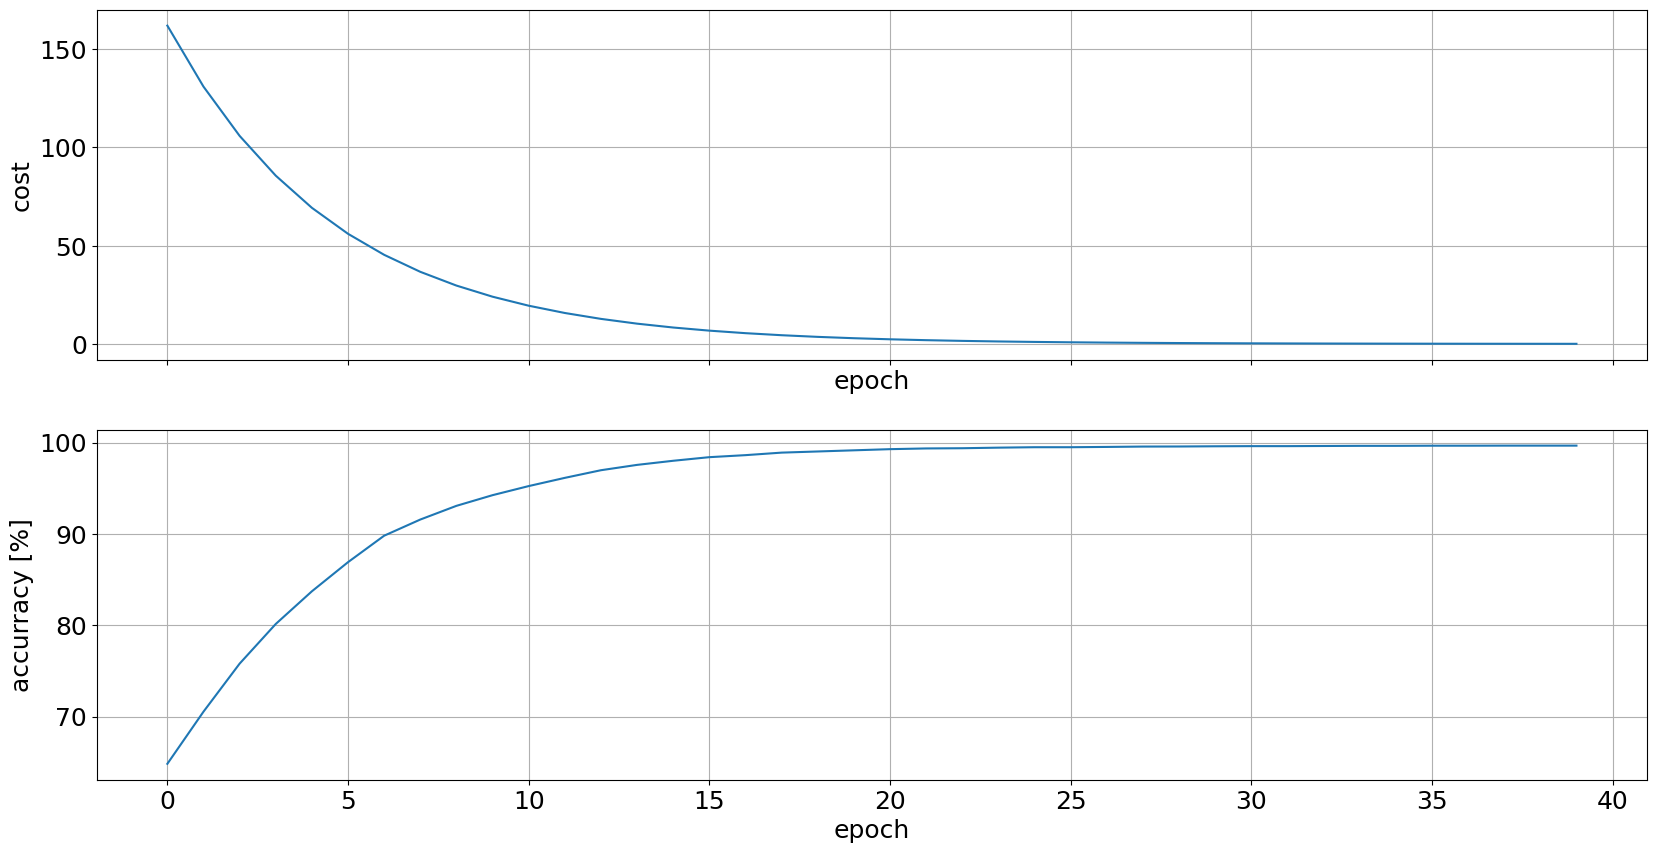

In [181]:
fig, ax = plt.subplots(2, 1, figsize=(20, 10), sharex=True)
ax[0].plot(range(len(values)), values)
ax[0].set_xlabel('epoch') ; ax[0].set_ylabel('cost')
ax[0].grid()
ax[1].plot(range(len(accurracies)), accurracies)
ax[1].set_xlabel('epoch') ; ax[1].set_ylabel('accurracy [%]')
ax[1].grid()
plt.show()

In [182]:
# Calculam acuratetea pentru setul de test
# Aceasta presupune sa numaram cate predictii se potrivesc cu realitatea
# si sa exprimam acest lucru procentual
pred = ((h(test_x_bin_ext, theta) >= 0.5) * 1 == test_y_bin)

print("accuracy: %2.2f%% for %d patterns" % (compute_accuracy(test_x_bin_ext, test_y_bin, theta) , test_x_bin_ext.shape[0]))

# Calculam confusion matrix
# true positive: y = 1 and pred = 1
# true negative: y = 0 and pred = 0
# false positive: y = 0 and pred = 1
# false negative: y = 1 and pred = 0
pred = (h(test_x_bin_ext, theta) >= 0.5) * 1
tp = np.sum(np.logical_and(pred == 1, test_y_bin == 1))
tn = np.sum(np.logical_and(pred == 0, test_y_bin == 0))
fp = np.sum(np.logical_and(pred == 1, test_y_bin == 0))
fn = np.sum(np.logical_and(pred == 0, test_y_bin == 1))

headers = ['Confusion Matrix', 'pred: 0', 'pred: 1', 'pred: all'] 
table = [
    ['actual: 0', tn, fp, tn + fp],
    ['actual: 1', fn, tp, fn + tp],
    ['actual: all', tn + fn, fp + tp, tn + fn + fp + tp]]
tab.table(table, headers, width=16)

accuracy: 99.86% for 2115 patterns
╭──────────────────┬──────────────────┬──────────────────┬──────────────────╮
│ Confusion Matrix │          pred: 0 │          pred: 1 │        pred: all │
├──────────────────┼──────────────────┼──────────────────┼──────────────────┤
│        actual: 0 │              978 │                2 │              980 │
│        actual: 1 │                1 │             1134 │             1135 │
│      actual: all │              979 │             1136 │             2115 │
╰──────────────────┴──────────────────┴──────────────────┴──────────────────╯


## Regresia logistică multinomială

In [183]:
# classes
k = 10

# Adaugam la features coloana de 1-uri
train_x_all_ext = add_ones_column(normalize(train_x))
test_x_all_ext = add_ones_column(normalize(test_x))

assert train_x_all_ext.shape == (60000, 785)
assert test_x_all_ext.shape == (10000, 785)
assert np.all(train_x_all_ext[:, 0] == 1)
assert np.all(test_x_all_ext[:, 0] == 1)
assert np.all(train_x_all_ext <= 1)
assert np.all(test_x_all_ext <= 1)
assert np.all(train_x_all_ext >= 0)
assert np.all(test_x_all_ext >= 0)

In [184]:
def one_hot(val: int, classes: int) -> np.ndarray:
    """
    Realizeaza 'one-hot encoding', conversia unui intreg la un array binar,
    care are 1 doar pe pozitia specificata de val
    
    Args:
        val: clasa ce trebuie encodata, un intreg intre {0, 1, ... K-1}
        classes: numarul de clase K
        
    Returns:
        un array de zerouri de lungime K, unde doar pe pozitia val avem o valoare 1
    """
    assert 0 <= val < classes
    result = np.zeros(classes)
    result = result.reshape(1, classes)
    result[0,val] = 1

    assert result.shape == (1, classes)
    return result

assert np.all(one_hot(7, k) == np.array([[0, 0, 0, 0, 0, 0, 0, 1, 0, 0]]))
assert np.all(one_hot(3, k) == np.array([[0, 0, 0, 1, 0, 0, 0, 0, 0, 0]]))

train_y_all = np.concatenate([one_hot(int(i), k) for i in train_y])
test_y_all = np.concatenate([one_hot(int(i), k) for i in test_y])
assert train_y_all.shape == (60000, 10)
assert test_y_all.shape == (10000, 10)
assert np.all((train_y_all != 0) == (train_y_all == 1))

Produsul $X \theta$ între matricea X de dimensiune (m, n) şi $\theta$ de dimensiune (n, k) va avea dimensiunea (m, k):

In [185]:
def prod(x, theta):
    """
    Product between X of shape (m x n) and theta of shape (n x k)
    
    Args:
        x: feature-urile, dimensiune m x n
        theta: parametrii, de dimensiune n x k
        
    Returns:
        produsul lor de dimensiune m x k
    """
    return np.dot(x,theta)

m, n = train_x_all_ext.shape
np.random.seed(11)
theta = np.random.randn(n, k)
assert prod(train_x_all_ext, theta).shape == (m, k)

Funcţia $softmax()$ va avea aceleaşi dimensiuni (m, k) şi trebuie să dea pe fiecare coloană suma 1. Se poate scrie compact calculul ei astfel:

$$softmax(X, \theta) = \frac{e^{X \theta}}{e^{X \theta} \cdot \mathbb{1}_k}$$

Termenul de la numitor, $e^{X \theta} \cdot \mathbb{1}_k$, nu mai este o matrice, ci un vector de dimensiunea (m, 1) (practic se realizează suma pe fiecare linie). Pentru realizarea împărţirii se realizează operaţia de broadcast.

In [186]:
def softmax(x, theta):
    """"
    Calculul functie softmax
    
    Args:
        x: feature-urile, dimensiune m x n
        theta: parametrii, de dimensiune n x k
        
    Returns:
        produsul lor de dimensiune m x k
    """
    assert x.shape[1] == theta.shape[0]
    # ...
    b = np.max(x,1)
    b=b[:, np.newaxis]
    exi = np.exp(np.dot(x,theta))
    div=(np.sum(exi, axis = 1))
    div = div[:,np.newaxis]
    return exi/div

m, n = train_x_all_ext.shape
np.random.seed(11)
theta = np.random.randn(n, k)
smax = softmax(train_x_all_ext, theta)
assert smax.shape == (m, k)
assert np.all((smax.sum(axis=1) - 1) < 1e-12)

Funcţia de cost ce include regularizarea poate fi scrisă mai compact astfel (a se remarca indicele de sumare $i$ plecand de la 1):

$$J(\theta, \lambda) = -\frac{1}{m} \mathbb{1}_m^T \left\{ Y \odot \log[softmax(X \theta)] \mathbb{1}_k \right\} + \frac{\lambda}{2} \sum_{i=1}^{n-1}\sum_{j=0}^{k-1} \theta_{i,j}^2 = -\frac{1}{m} \mathbb{1}_m^T \left\{ Y \odot \log[softmax(X \theta)] \mathbb{1}_k \right\} + \frac{\lambda}{2} \|\Theta[1:, :]\|_F^2$$

unde pentru o matrice $A$ de tip $m\times n$, $\| A \|_F$ e norma Forbenius: $\| A \|_F = \sqrt{\sum\limits_{i=0}^{m-1}\sum\limits_{j=0}^{n-1} |a_{ij}|^2}$

In [187]:
def cost(x, y, theta, lmbda):
    """
    Costul include regularizarea
    
    Args:
        x: feature-urile, dimensiune m x n
        y: clasele, de dimensiune m x k
        theta: parametrii, de dimensiune n x k
        lmbda: parametrul de regularizare, scalar
        
    Returns:
        costul, ca scalar

    """

    return -np.sum(np.multiply(y,np.log(softmax(x,theta)))) / x.shape[0] + lmbda * np.sum(theta ** 2) / (2 * x.shape[0])

m, n = train_x_all_ext.shape
np.random.seed(11)
theta = np.random.randn(n, k)
assert (cost(train_x_all_ext, train_y_all, theta=theta, lmbda=0.2) - 804.384938) < 1e-6

Gradientul se calculează astfel:

$$\nabla_{\theta}J = - \frac{1}{m} X^T \left[Y - softmax(X \theta) \right] + \lambda \left[ \mathbb{0}_n, \theta_{1 \dots k-1} \right]$$

unde matricea $\left[ \mathbb{0}_n, \theta_{1 \dots k-1} \right]$ are tot dimensiunea (n, k), ca şi $\theta$, doar că prima linie este zero.

In [188]:
def deltas(x, y, theta, lmbda):
    """
    Calculeaza gradientul

    Args:
        x: feature-urile, dimensiune m x n
        y: clasele, de dimensiune m x k
        theta: parametrii, de dimensiune n x k
        lmbda: parametrul de regularizare, scalar
        
    Returns:
        matricea gradientilor, de dimensiunea lui theta (n x k)
    """
    theta_simple = theta.copy()
    theta_simple[0] = 0
    j1 = (-1/m) * np.dot(np.transpose(x),np.subtract(y,softmax(x,theta)))
    j2=np.multiply(lmbda,theta_simple)
    return j1+j2

m, n = train_x_all_ext.shape
np.random.seed(11)
theta = np.random.randn(n, k)
grad = deltas(train_x_all_ext, train_y_all, theta=theta, lmbda=0.2)
assert grad.shape == (n, k)
assert (grad.sum() + 6.0286086) < 1e-6

In [189]:
def calculate_accurracy(set_x, set_y, theta):
    pred = ((h(set_x, theta) >= 0.5) * 1 == set_y)
    return 100.0 * sum(pred) / pred.shape[0]

In [190]:
# numarul de clase
k = 10

lmbda, alpha = 0.05, 0.65
m, n = train_x_all_ext.shape
np.random.seed(11)
theta = np.random.randn(n, k)

epochs = 300
values = []
accurracies = []
for i in range(epochs):
    theta -= alpha * deltas(train_x_all_ext, train_y_all, theta, lmbda)
    if (i % 10 == 0):
        values.append(cost(train_x_all_ext, train_y_all, theta, lmbda))
        accurracies.append(calculate_accurracy(test_x_all_ext, test_y_all, theta))
        print("epoch: ", i, "cost: ", values[-1])
        lmbda *= 0.9
    
print("last costs: %g" % values[-1])

epoch:  0 cost:  9.959145299994411
epoch:  10 cost:  3.0854295005230146
epoch:  20 cost:  1.5309674593899554
epoch:  30 cost:  0.9997080299177994
epoch:  40 cost:  0.7725408598995334
epoch:  50 cost:  0.6609110870162868
epoch:  60 cost:  0.599573580276406
epoch:  70 cost:  0.5619205236158532
epoch:  80 cost:  0.5360939529683271
epoch:  90 cost:  0.5165615345672598
epoch:  100 cost:  0.5006502219279269
epoch:  110 cost:  0.4870142338677028
epoch:  120 cost:  0.4749403500419269
epoch:  130 cost:  0.46402728104651336
epoch:  140 cost:  0.454034047008156
epoch:  150 cost:  0.44480590633008477
epoch:  160 cost:  0.436236766560626
epoch:  170 cost:  0.4282493240486062
epoch:  180 cost:  0.4207841402254683
epoch:  190 cost:  0.4137933960246403
epoch:  200 cost:  0.4072371873505705
epoch:  210 cost:  0.40108124989551797
epoch:  220 cost:  0.39529551452854983
epoch:  230 cost:  0.38985315999400144
epoch:  240 cost:  0.38472997170000267
epoch:  250 cost:  0.37990389376262196
epoch:  260 cost:  0

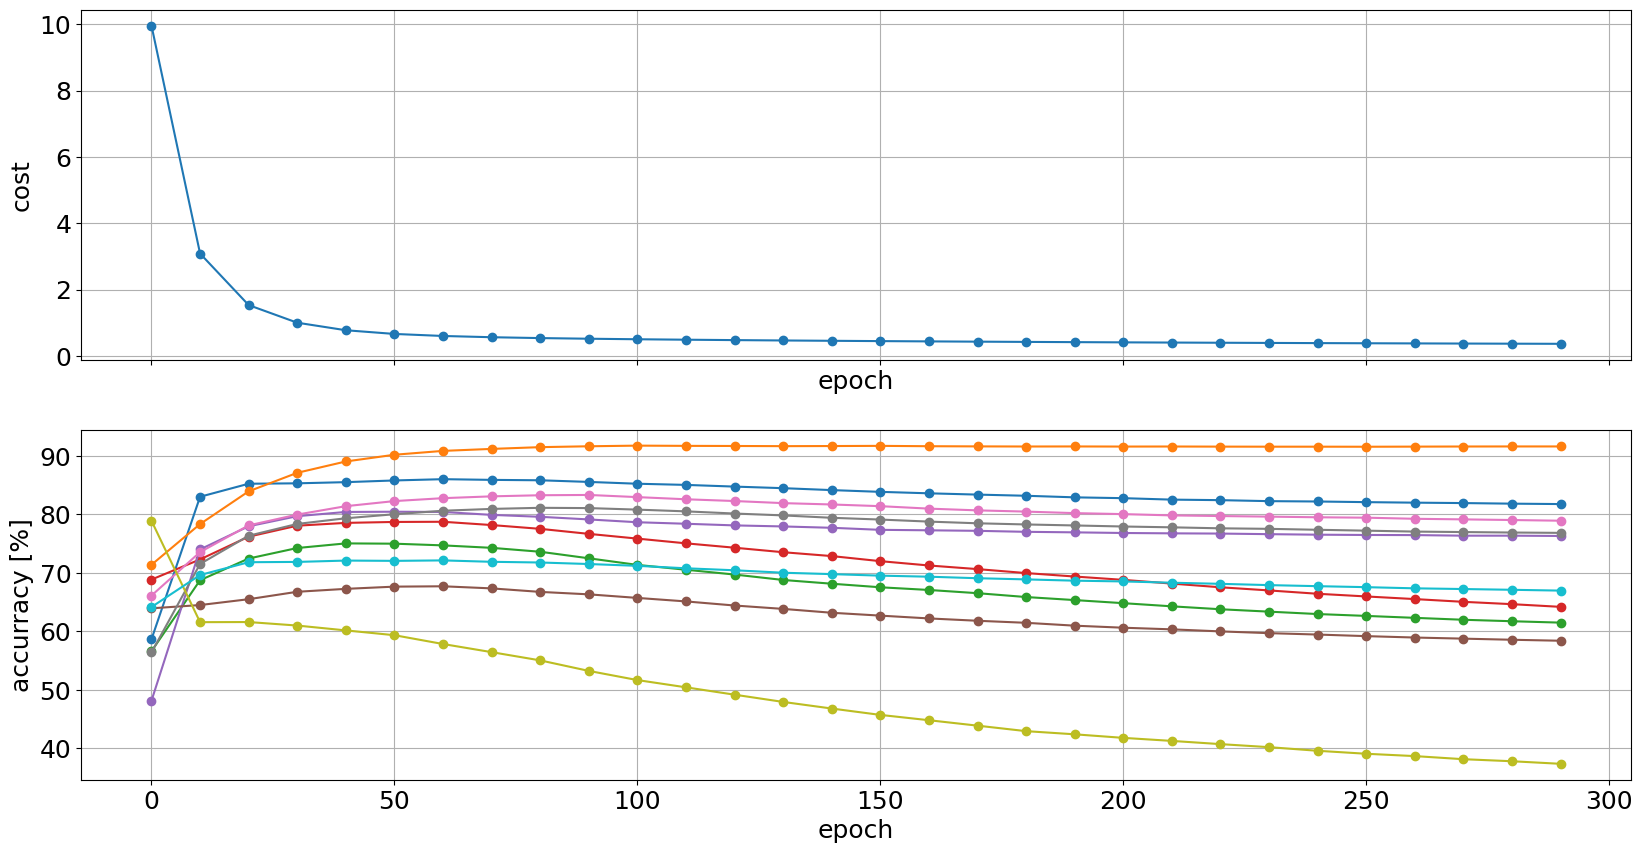

In [191]:
fig, ax = plt.subplots(2, 1, figsize=(20, 10), sharex=True)
ax[0].plot([x * 10 for x in range(len(values))], values, 'o-')
ax[0].set_xlabel('epoch') ; ax[0].set_ylabel('cost')
ax[0].grid()
ax[1].plot([x * 10 for x in range(len(accurracies))], accurracies, 'o-')
ax[1].set_xlabel('epoch') ; ax[1].set_ylabel('accurracy [%]')
ax[1].grid()
plt.show()

In [192]:
# Calculam acuratetea pentru setul de test
# Aceasta presupune sa numaram cate predictii se potrivesc cu realitatea si sa exprimam acest lucru procentual
pred = ((h(test_x_all_ext, theta) >= 0.5) * 1 == test_y_all)
actual = ...
equalities = np.sum(pred == actual)
print("Test accuracy: %2.2f%%" % ( calculate_accurracy(test_x_all_ext, test_y_all, theta) ,  test_x_all_ext.shape[0]))



TypeError: only size-1 arrays can be converted to Python scalars

In [ ]:
# Calculam vectorii predictiilor precum si vectorul realitatii
pred = ...
actual = ...

# Confusion matrix va avea la intersectia linie/coloana cate sample-uri din clasa data de numarul liniei
# au fost prezise ca fiind facand parte din clasa data de numarul coloanei
conf_matrix = ...
# ...

assert len(conf_matrix) == k
assert (sum(len(row) for row in conf_matrix)) == k ** 2

    
headers = ['CnfMat'] + [f'pr: {x}' for x in range(k)] + ['all a'] 
table = []
for i in range(k):
    table.append([f'act: {i}'] + ... )
table.append( ... )

tab.table(table, headers, width=6)